In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 10.3 MB/s eta 0:00:00


In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import resample
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.optimizers import Adam 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('/kaggle/input/arrythmia-beats/beats.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,-0.359115,-0.290379,-0.323573,-0.307218,-0.316645,-0.321637,-0.306067,-0.302599,-0.298502,-0.299659,...,-0.414052,-0.431847,-0.425296,-0.450239,-0.441885,-0.461390,-0.455039,-0.464502,-0.458949,0
1,-0.331590,-0.359151,-0.342719,-0.347785,-0.329609,-0.348510,-0.337670,-0.349326,-0.340564,-0.338450,...,-0.410252,-0.411724,-0.423127,-0.414775,-0.434438,-0.416298,-0.426213,-0.398806,-0.374722,0
2,-0.359694,-0.362858,-0.356012,-0.353829,-0.349271,-0.358797,-0.363903,-0.367123,-0.356742,-0.361979,...,-0.374593,-0.387517,-0.373483,-0.384780,-0.366351,-0.394924,-0.366355,-0.369437,-0.312160,0
3,-0.339981,-0.352648,-0.351186,-0.350171,-0.339069,-0.360647,-0.354735,-0.349480,-0.335290,-0.337053,...,-0.424496,-0.430142,-0.447108,-0.452515,-0.452510,-0.425352,-0.451367,-0.414900,-0.420923,0
4,-0.366317,-0.332309,-0.335611,-0.321932,-0.329447,-0.330804,-0.336630,-0.332348,-0.332618,-0.341589,...,-0.393476,-0.423857,-0.409874,-0.440441,-0.430977,-0.445994,-0.436363,-0.445539,-0.424348,0


In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [5]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)

In [6]:
# Check explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.50566777 0.21917854 0.09439045 0.05441103 0.04253188 0.02191155
 0.01160706 0.00989394]


In [7]:
# Convert back to DataFrame
df = pd.DataFrame(X_pca)
df['Target'] = y

df.head()

,0,1,2,3,4,5,6,7,Target
0,0.077544,0.185870,-0.757876,-0.265694,-0.125441,0.433201,-0.214613,-0.191826,0
1,-0.023355,0.504961,-0.739108,-0.262781,-0.000146,0.521998,-0.112068,-0.293593,0
2,-0.033717,0.667187,-0.660976,-0.313764,0.111490,0.517625,-0.129570,-0.226769,0
3,-0.055630,0.639269,-0.855417,-0.129850,-0.003671,0.482379,-0.142944,-0.260567,0
4,0.008995,0.539357,-0.823392,-0.138061,-0.038075,0.516807,-0.176810,-0.287622,0


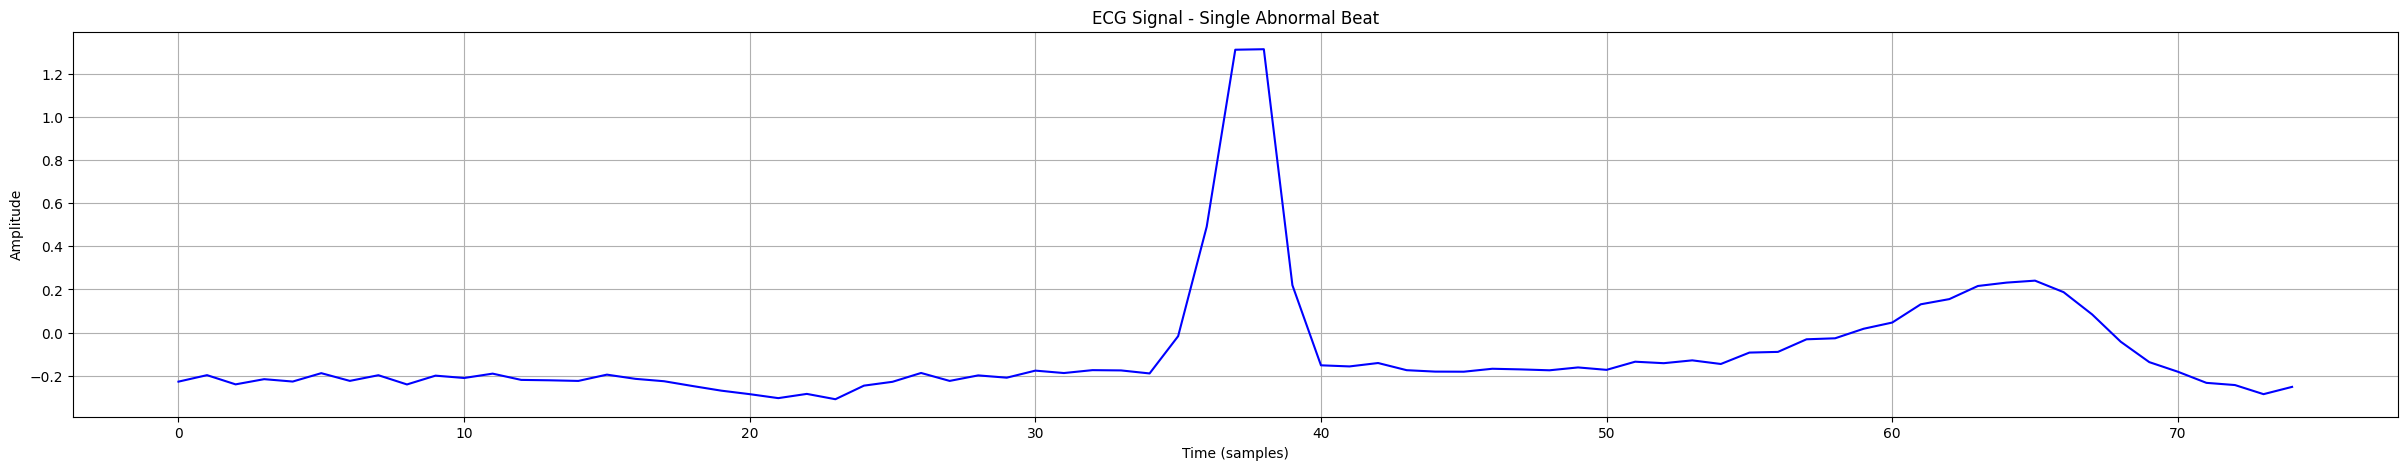

In [8]:
beat = data[data.iloc[:, -1] == 1].iloc[0, :-1].values  
beat = beat.astype(float)  

plt.figure(figsize=(30, 5))
plt.plot(beat, color='blue', linewidth=1.5)
plt.title('ECG Signal - Single Abnormal Beat')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.savefig('Abnormal_beat_plot.png')
plt.show()

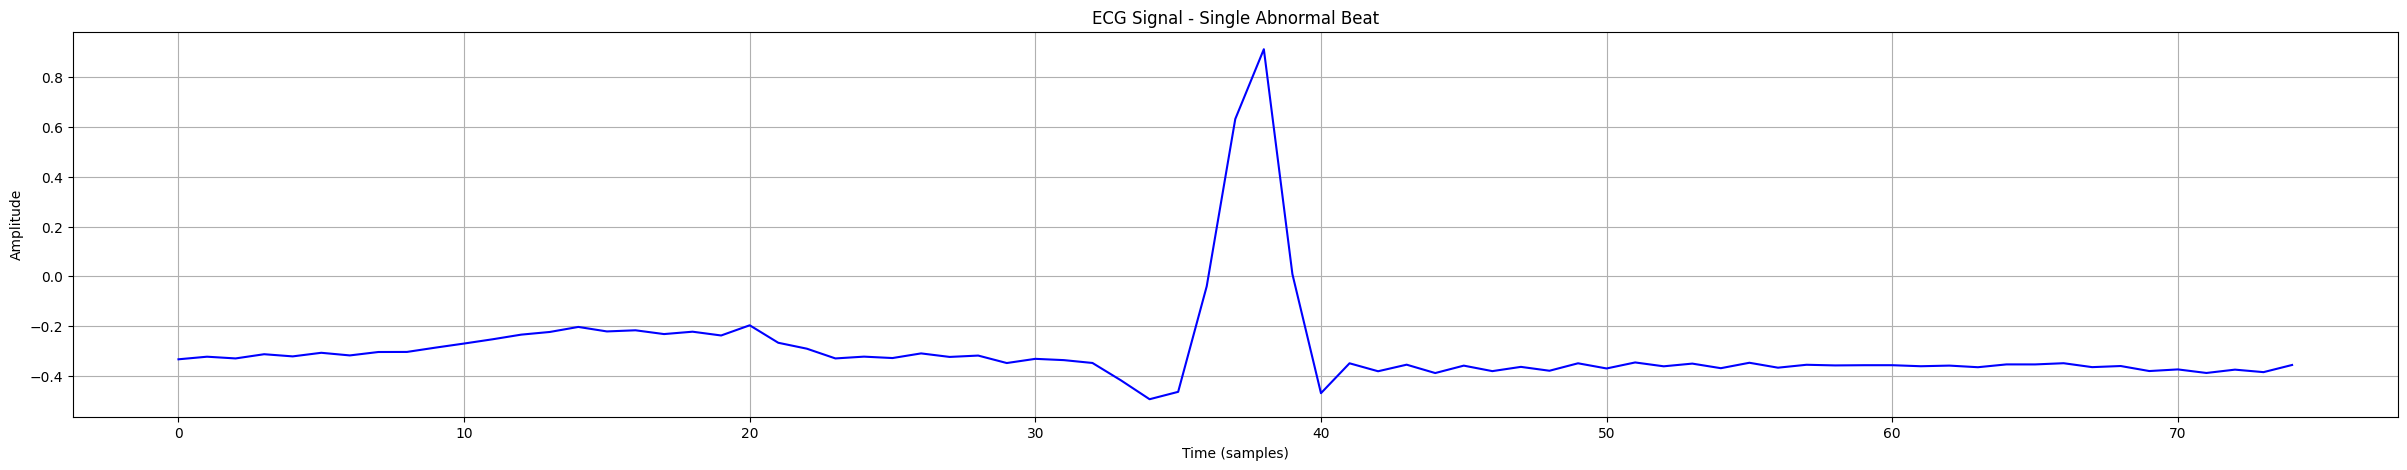

In [9]:
beat = data[data.iloc[:, -1] == 0].iloc[11, :-1].values  
beat = beat.astype(float)  

plt.figure(figsize=(30, 5))
plt.plot(beat, color='blue', linewidth=1.5)
plt.title('ECG Signal - Single Abnormal Beat')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.savefig('Abnormal_beat_plot.png')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112532 entries, 0 to 112531
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       112532 non-null  float64
 1   1       112532 non-null  float64
 2   2       112532 non-null  float64
 3   3       112532 non-null  float64
 4   4       112532 non-null  float64
 5   5       112532 non-null  float64
 6   6       112532 non-null  float64
 7   7       112532 non-null  float64
 8   Target  112532 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 7.7 MB


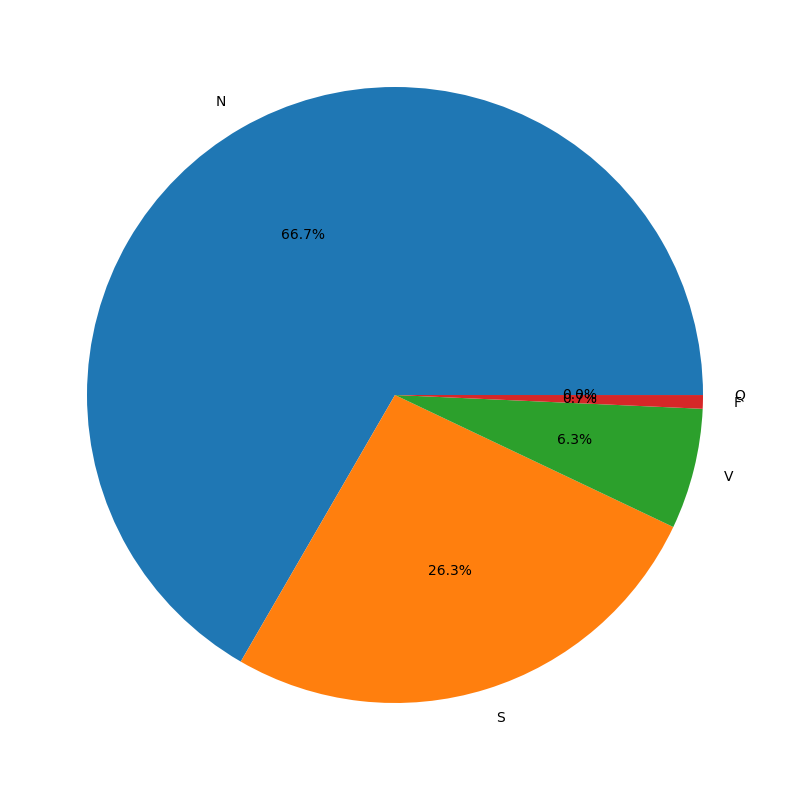

In [11]:
per_classes = df.iloc[:, -1].value_counts()
plt.figure(figsize=(20,10))
plt.pie(per_classes, labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%')
plt.show()

In [12]:
df = df[df.iloc[:, -1] != 1]
df.iloc[:, -1].value_counts()

Target
0    75005
4    29594
2     7129
3      802
Name: count, dtype: int64

In [13]:
X = df.iloc[:, :-1]
X.head()

,0,1,2,3,4,5,6,7
0,0.077544,0.185870,-0.757876,-0.265694,-0.125441,0.433201,-0.214613,-0.191826
1,-0.023355,0.504961,-0.739108,-0.262781,-0.000146,0.521998,-0.112068,-0.293593
2,-0.033717,0.667187,-0.660976,-0.313764,0.111490,0.517625,-0.129570,-0.226769
3,-0.055630,0.639269,-0.855417,-0.129850,-0.003671,0.482379,-0.142944,-0.260567
4,0.008995,0.539357,-0.823392,-0.138061,-0.038075,0.516807,-0.176810,-0.287622


In [14]:
y = df.iloc[:, -1]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64

In [15]:
print(f"The Shape of the X: {X.shape}")
print(f"The Shape of the y: {y.shape}")

The Shape of the X: (112530, 8)
The Shape of the y: (112530,)


In [16]:
# First, split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the train set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [17]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (67518, 8)
The shape of X_test: (22506, 8)
The shape of X_valid: (22506, 8)
The length of y_train: 67518
The length of y_test: 22506
The shape of y_valid: 22506


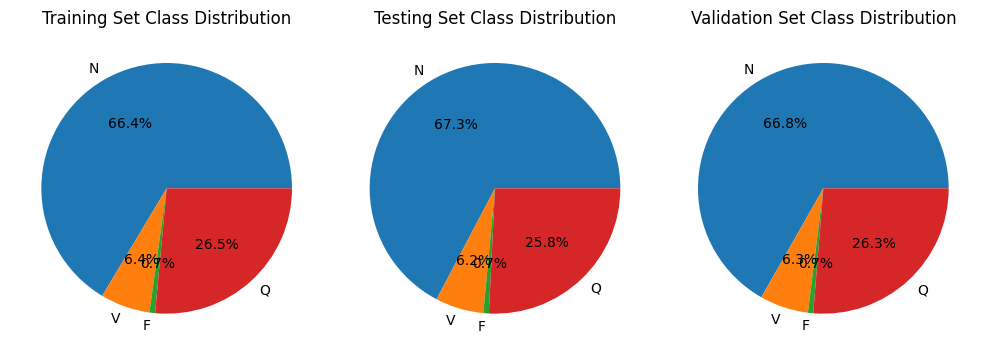

In [18]:
# Compute class distributions for training and testing sets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
valid_classes, valid_counts = np.unique(y_valid, return_counts=True)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(10, 8))

# Plot the Training Set Distribution
axes[0].pie(train_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[0].set_title('Training Set Class Distribution')

# Plot the Testing Set Distribution
axes[1].pie(test_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[1].set_title('Testing Set Class Distribution')

# Plot the validation Set Distribution
axes[2].pie(valid_counts, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
axes[2].set_title('Validation Set Class Distribution')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [19]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))


(67518, 8, 1)
<class 'numpy.ndarray'>
(22506, 8, 1)
<class 'numpy.ndarray'>
(22506, 8, 1)
<class 'numpy.ndarray'>


In [20]:
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(67518,)
(22506,)
(22506,)


In [21]:
train_y=to_categorical(y_train)
test_y=to_categorical(y_test)
valid_y=to_categorical(y_valid)
print(np.shape(train_y), np.shape(test_y), np.shape(valid_y))

(67518, 5) (22506, 5) (22506, 5)


In [22]:
train_x = np.array(train_x, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)

test_x = np.array(test_x, dtype=np.float32)
test_y = np.array(test_y, dtype=np.float32)

valid_x = np.array(valid_x, dtype=np.float32)
valid_y = np.array(valid_y, dtype=np.float32)


In [23]:
# Define CNN model
model = Sequential()

# First Convolutional Layer (Reduced kernel size)
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(8, 1)))
model.add(MaxPooling1D(pool_size=2, strides=1))  # Adjusted pooling

# Second Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=1))  

# Third Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=1))  

# Flattening the feature maps
model.add(Flatten())

# Fully connected layers with Dropout
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax activation for 5-class classification
model.add(Dense(5, activation='softmax'))

# Display model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 16)               │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,295 (98.81 KB)

 Trainable params: 25,295 (98.81 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(
    loss='categorical_crossentropy',  # Suitable for binary classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy']  # Track accuracy during training
)

In [25]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model weights after stopping
)

In [26]:
# Define a ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_ecg_model.keras',  # Change the extension to .keras
    monitor='val_loss',              # Monitor validation loss
    save_best_only=True,             # Save only the best model based on val_loss
    mode='min',                      # Save model when val_loss is minimized
    verbose=1                        # Print a message when saving the model
)

In [27]:
# Train the model
history = model.fit(
    train_x, train_y,
    batch_size=42,  # Number of samples per batch
    epochs=100,  # Train for up to 50 epochs
    verbose=1,  # Show training progress
    validation_data=(valid_x, valid_y),  # Validate on test data
    callbacks=[early_stopping, checkpoint]  # Apply early stopping and checkpoint
)

Epoch 1/100
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4954 - loss: 1.2557
Epoch 1: val_loss improved from inf to 0.52097, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.4955 - loss: 1.2556 - val_accuracy: 0.7965 - val_loss: 0.5210
Epoch 2/100
1580/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7821 - loss: 0.5816
Epoch 2: val_loss improved from 0.52097 to 0.35331, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7825 - loss: 0.5807 - val_accuracy: 0.8861 - val_loss: 0.3533
Epoch 3/100
1606/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.4264
Epoch 3: val_loss improved from 0.35331 to 0.28479, saving model to best_ecg_model.keras
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8629 - loss: 0.4264 - val_accuracy: 0.9094 - val_loss: 0.2848
Epoch 4/100
1590/1608 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3525
Epoch 4: val_loss impro

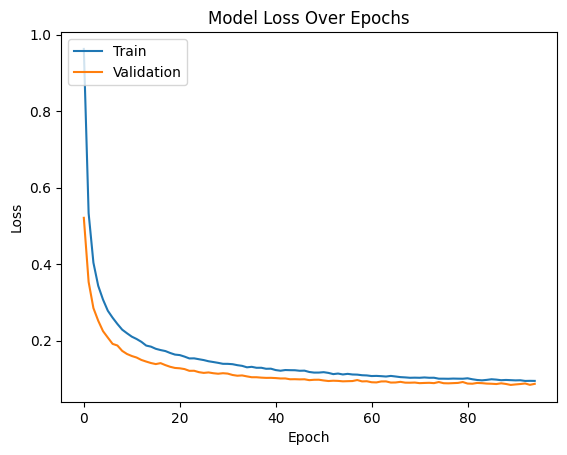

In [28]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Set the title and axis labels
plt.title('Model Loss Over Epochs')  # Title of the plot
plt.ylabel('Loss')  # Y-axis label (Loss)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation loss
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')

# Display the plot
plt.show()

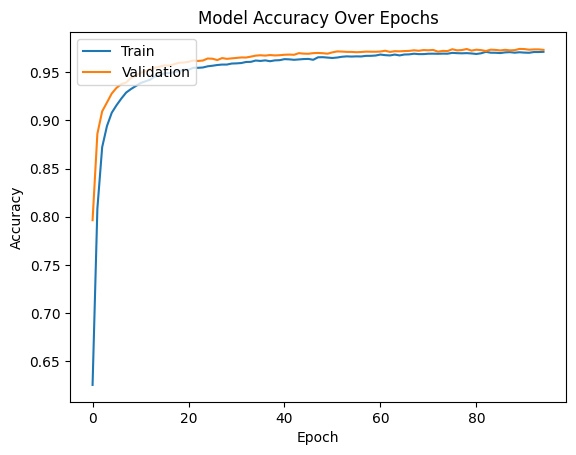

In [29]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy

# Set the title and axis labels
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label (Accuracy)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation accuracy
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')

# Display the plot
plt.show()

In [30]:
model.predict(test_x)


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[4.0324489e-05, 2.5325671e-22, 2.0274329e-04, 1.3856462e-06,
        9.9975556e-01],
       [9.5227343e-01, 2.3956736e-11, 1.4920780e-03, 7.4356073e-03,
        3.8798757e-02],
       [9.2300123e-01, 2.7011353e-12, 1.5387614e-03, 2.8015526e-03,
        7.2658360e-02],
       ...,
       [9.9808717e-01, 4.8704270e-19, 3.1211348e-05, 3.4139180e-04,
        1.5402747e-03],
       [1.9866307e-03, 1.6393793e-16, 1.5308774e-03, 5.9744685e-05,
        9.9642271e-01],
       [9.9993420e-01, 4.1037489e-33, 7.0757866e-09, 9.1399801e-07,
        6.4822241e-05]], dtype=float32)

In [31]:
# Evaluate the trained model on the test dataset
score = model.evaluate(test_x, test_y)

# Print the test loss
print(f'Test Loss: {score[0]:.4f}')  # Display test loss with 4 decimal precision

# Print the test accuracy
print(f'Test Accuracy: {score[1] * 100:.2f}%')

704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9768 - loss: 0.0776
Test Loss: 0.0827
Test Accuracy: 97.55%


704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


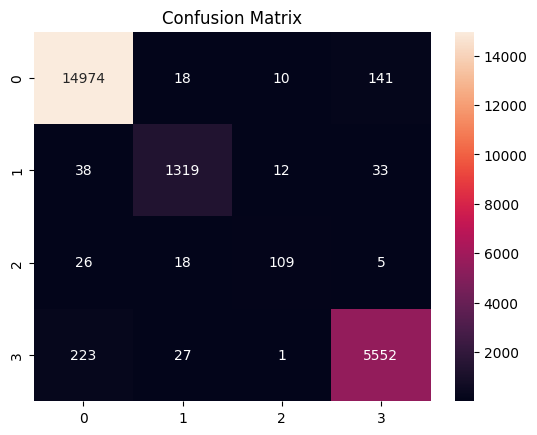

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d',ax=ax)
ax.set_title('Confusion Matrix'); 
plt.savefig('cm')

In [33]:
from sklearn.metrics import classification_report

cf = classification_report(y_true, prediction,digits=4)
print(cf)

              precision    recall  f1-score   support

           0     0.9812    0.9888    0.9850     15143
           2     0.9544    0.9408    0.9476      1402
           3     0.8258    0.6899    0.7517       158
           4     0.9688    0.9567    0.9627      5803

    accuracy                         0.9755     22506
   macro avg     0.9325    0.8941    0.9118     22506
weighted avg     0.9752    0.9755    0.9753     22506

